In [1]:
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
idx2name = pkl.load(open('data/hierarchies/tieredimagenet/tieredimagenet_idx_to_name.pkl', 'rb'))
class2idx = pkl.load(open('data/hierarchies/tieredimagenet/tieredimagenet_class_to_idx.pkl', 'rb'))

In [2]:
from torchvision import transforms

/home/infres/rplaud/miniconda3/envs/hitin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
t = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

In [4]:
# open ILSVRC2012_val_00047737.JPEG and apply the transform
from PIL import Image
img = Image.open('ILSVRC2012_val_00047737.JPEG')
img = t(img)

imgs_blurred = [img]

for sigma in np.linspace(1/10, 10, 100):
    t_blurred = transforms.GaussianBlur(kernel_size=61, sigma=sigma)
    img_blurred = t_blurred(img)
    imgs_blurred.append(img_blurred)
imgs_blurred = torch.stack(imgs_blurred)

In [5]:
from torchvision.models import (
    alexnet, AlexNet_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights,
    densenet121, DenseNet121_Weights,
    efficientnet_v2_s, EfficientNet_V2_S_Weights,
    inception_v3, Inception_V3_Weights,
    resnet18, ResNet18_Weights,
    swin_v2_t, Swin_V2_T_Weights,
    vgg11, VGG11_Weights,
    vit_b_16, ViT_B_16_Weights,
)

In [6]:
MODEL_REGISTRY = {
    'alexnet': (alexnet, AlexNet_Weights),
    'convnext_tiny': (convnext_tiny, ConvNeXt_Tiny_Weights),
    'densenet121': (densenet121, DenseNet121_Weights),
    'efficientnet_v2_s': (efficientnet_v2_s, EfficientNet_V2_S_Weights),
    'inception_v3': (inception_v3, Inception_V3_Weights),
    'resnet18': (resnet18, ResNet18_Weights),
    'swin_v2_t': (swin_v2_t, Swin_V2_T_Weights),
    'vgg11': (vgg11, VGG11_Weights),
    'vit_b_16': (vit_b_16, ViT_B_16_Weights),
}

In [7]:
def get_pretrained_model(model_name: str):
    """
    Return a model constructor and weights given a model name.
    """
    if model_name not in MODEL_REGISTRY:
        raise ValueError(f"Unknown model '{model_name}'. Available: {list(MODEL_REGISTRY)}")

    constructor, weights_cls = MODEL_REGISTRY[model_name]
    return constructor, weights_cls


In [8]:
model_constructor, weights_cls = get_pretrained_model('vgg11')
weights = weights_cls.IMAGENET1K_V1
model = model_constructor(weights=weights)

In [9]:
idx_mapping = pkl.load(open('data/hierarchies/tieredimagenet/tiredimagenet_corresponding_index.pkl', 'rb'))

In [10]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [11]:
indices = [idx_mapping[key] for key in idx_mapping]
indices = torch.tensor(indices, dtype=torch.long)

# Get original weights and bias
old_weight = model.classifier[6].weight.data
old_bias = model.classifier[6].bias.data

# Prune
new_weight = old_weight[indices]
new_bias = old_bias[indices]

# Replace parameters
model.classifier[6].weight = nn.Parameter(new_weight)
model.classifier[6].bias = nn.Parameter(new_bias)
model.classifier[6].out_features = len(indices)

In [12]:
proba_leaves = model.forward(imgs_blurred)

In [13]:
# apply softmax to axis 1
proba_leaves = F.softmax(proba_leaves, dim=1)
proba_leaves = proba_leaves.detach().cpu().numpy()

In [14]:
import hierulz.hierarchy.hierarchy as hhh
import importlib
importlib.reload(hhh)

<module 'hierulz.hierarchy.hierarchy' from '/home/infres/rplaud/hierarchical_decision_rules/hierulz/hierarchy/hierarchy.py'>

In [15]:
from hierulz.hierarchy import Hierarchy, load_hierarchy


In [16]:
h = load_hierarchy('data/hierarchies/tieredimagenet/tieredimagenet_hierarchy_idx.pkl')

In [17]:
proba_nodes = h.get_probas(proba_leaves)

In [18]:
from hierulz.metrics import load_metric, hFBetaScore, Accuracy
from hierulz.heuristics import TopDown, Plurality

In [19]:
m = hFBetaScore(hierarchy=h, beta=1.0)
argmax = Accuracy(hierarchy=h)
top_down_heuristic = TopDown(hierarchy=h)
plurality_heuristic = Plurality(hierarchy=h)

In [20]:
pred_opt = m.decode(proba_nodes)

In [21]:
pred_argmax = argmax.decode(proba_nodes)

In [22]:
pred_top_down = top_down_heuristic.decode(proba_nodes)
pred_plurality = plurality_heuristic.decode(proba_nodes)

In [23]:
def decode_pred(pred, h, idx2name):
    labels = np.where(pred)[0]
    pred = [h.root_idx]
    bool=True
    while bool:
        bool_i = False
        for l in pred:
            if l in h.leaves_idx:
                pass
            # del l from pred and add the children of l to pred
            else :
                inter = list(set(h.hierarchy_dico_idx[l]).intersection(set(labels)))
                if len(inter) > 0:
                    pred.remove(l)
                    pred.extend(inter)
                    bool_i = True
        bool = bool_i
    return [idx2name[p] for p in pred]


In [24]:
h.hierarchy_dico_idx[h.root_idx]

[747, 733]

In [25]:
proba_nodes[0]

array([8.26793993e-08, 3.22700160e-08, 2.89232336e-08, 2.67598210e-08,
       2.61882889e-08, 3.02887344e-07, 1.90360865e-07, 2.40271292e-09,
       2.80545787e-09, 6.55754784e-10, 8.77528716e-10, 7.99340860e-09,
       9.21544263e-09, 2.65646816e-09, 1.42205025e-07, 1.08630447e-08,
       3.95379507e-09, 2.57286681e-09, 5.13919185e-10, 1.56183670e-08,
       1.96895286e-07, 1.43395396e-09, 7.84673038e-09, 3.22282911e-09,
       3.19609050e-09, 4.10437018e-09, 8.42095034e-08, 5.45278844e-09,
       4.93680581e-08, 2.25365238e-08, 2.41512428e-08, 1.92707752e-08,
       1.82714359e-07, 8.53027515e-09, 4.22895248e-08, 5.63829650e-09,
       2.05704353e-07, 1.22481174e-06, 5.66209224e-07, 5.24346753e-08,
       7.94287480e-09, 8.17197474e-08, 1.99193142e-08, 5.57010038e-09,
       2.12269438e-08, 3.13200155e-09, 1.34906986e-06, 1.06984022e-08,
       1.51018935e-06, 1.13034460e-07, 5.71608929e-08, 3.77787890e-09,
       2.11277804e-08, 1.00304369e-08, 2.28177957e-08, 7.28717930e-09,
      

In [26]:
y_pred = [decode_pred(pred_opt[i], h, idx2name) for i in range(len(pred_opt))]
y_pred_argmax = [decode_pred(pred_argmax[i], h, idx2name) for i in range(len(pred_argmax))]
y_pred_top_down = [decode_pred(pred_top_down[i], h, idx2name) for i in range(len(pred_top_down))]
y_pred_plurality = [decode_pred(pred_plurality[i], h, idx2name) for i in range(len(pred_plurality))]

In [27]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as f


In [28]:
imgs_blurred_np = []
for i in range(len(imgs_blurred)):
    img_np = ((imgs_blurred[i] - imgs_blurred[i].min()) / (imgs_blurred[i].max() - imgs_blurred[i].min())).numpy()
    imgs_blurred_np.append(img_np.transpose(1, 2, 0))
imgs_blurred_np = np.array(imgs_blurred_np)

In [ ]:
import matplotlib.pyplot as plt

def plot_image_with_pred(img, pred_dict, label, numero):
    fig, ax = plt.subplots()
    ax.imshow(img)

    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    y_start = 20  # Start just above the image
    line_height = 40  # Vertical space between method rows

    for i, (method_name, preds) in enumerate(pred_dict.items()):
        x_offset = 230
        y_offset = y_start + i * line_height

        # Plot method name first
        method_text = ax.text(x_offset, y_offset, f"{method_name}:", fontsize=12,
                              color='black', weight='bold',
                            #   bbox=dict(facecolor='white', alpha=0.6),
                              transform=ax.transData)
        fig.canvas.draw()
        method_bbox = method_text.get_window_extent(renderer=renderer)
        inv = ax.transData.inverted()
        data_bbox = inv.transform([(method_bbox.x0, method_bbox.y0), (method_bbox.x1, method_bbox.y1)])
        method_width = data_bbox[1][0] - data_bbox[0][0]
        x_offset += method_width + 5

        # Plot predictions
        for p in preds:
            color = 'green' if p in label else 'red'
            pred_text = ax.text(x_offset, y_offset, p,
                                fontsize=12,
                                color=color,
                                # bbox=dict(facecolor='white', alpha=0.5),
                                transform=ax.transData)
            fig.canvas.draw()
            bbox = pred_text.get_window_extent(renderer=renderer)
            data_bbox = inv.transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
            text_width = data_bbox[1][0] - data_bbox[0][0]
            x_offset += text_width + 5

    ax.axis('off')
    # save the figure
    plt.savefig(f'frames/fig_{numero}.png', bbox_inches='tight', dpi=300)
    #close the figure
    plt.close(fig)

In [75]:
label = np.where(h.leaf_events[117])[0]
label_names = [idx2name[a] for a in label]

In [ ]:
def produce_pred_dict(i):
    pred_dict = {
    'Optimal': y_pred[i],
    'Argmax': y_pred_argmax[i],
    'Top Down': y_pred_top_down[i],
    'Plurality': y_pred_plurality[i]
    }
    return pred_dict

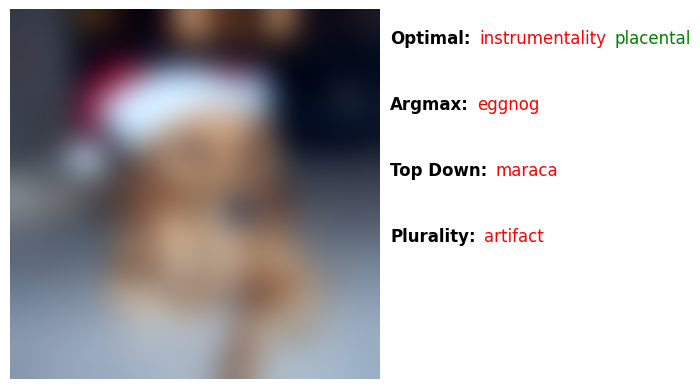

In [77]:
plot_image_with_pred(imgs_blurred_np[-6], pred_dict, label_names)

In [78]:
import os